In [1]:
# Necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.compose import TransformedTargetRegressor
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_absolute_error,r2_score
import lightgbm as lgb
import optuna

In [2]:
# Read data
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [3]:
# Check shape
train.shape

(74051, 10)

In [4]:
# Data info
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74051 entries, 0 to 74050
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              74051 non-null  int64  
 1   Sex             74051 non-null  object 
 2   Length          74051 non-null  float64
 3   Diameter        74051 non-null  float64
 4   Height          74051 non-null  float64
 5   Weight          74051 non-null  float64
 6   Shucked Weight  74051 non-null  float64
 7   Viscera Weight  74051 non-null  float64
 8   Shell Weight    74051 non-null  float64
 9   Age             74051 non-null  int64  
dtypes: float64(7), int64(2), object(1)
memory usage: 5.6+ MB


There are 74051 enteries with 10 columns. the data set has no null values

In [5]:
# See first 5 rows
train.head()

,id,Sex,Length,Diameter,Height,Weight,Shucked Weight,Viscera Weight,Shell Weight,Age
0,0,I,1.5250,1.1750,0.3750,28.973189,12.728926,6.647958,8.348928,9
1,1,I,1.1000,0.8250,0.2750,10.418441,4.521745,2.324659,3.401940,8
2,2,M,1.3875,1.1125,0.3750,24.777463,11.339800,5.556502,6.662133,9
3,3,F,1.7000,1.4125,0.5000,50.660556,20.354941,10.991839,14.996885,11
4,4,I,1.2500,1.0125,0.3375,23.289114,11.977664,4.507570,5.953395,8


In [6]:
# Drop id column as it is un-informative
train.drop(columns='id',axis=1,inplace=True)
test.drop(columns='id',axis=1,inplace=True)

# Replace whitespaces in column names with underscore
train.columns=train.columns.str.replace(' ','_')
test.columns=test.columns.str.replace(' ','_')

In [7]:
# Check duplicates
train.duplicated().sum()

0

There are no duplicates in this data and from observing the dataframe, only the sex column is categorical. Age is our target variable

In [8]:
# Change sex column to category type
train.Sex=train.Sex.astype('category')

# Check sex column to see its values
train.Sex.value_counts()

M    27084
I    23957
F    23010
Name: Sex, dtype: int64

There are 3 categories under the sex columns

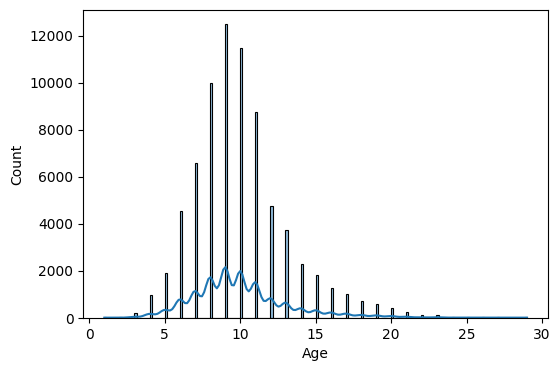

In [9]:
# Check distribution of target column
plt.figure(figsize=(6,4),)
sns.histplot(x=train['Age'],kde=True,edgecolor='black',linewidth=0.8)
plt.show()

In [10]:
# Check the distribution of numeric columns
train.describe()

,Length,Diameter,Height,Weight,Shucked_Weight,Viscera_Weight,Shell_Weight,Age
count,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000,74051.000000
mean,1.317460,1.024496,0.348089,23.385217,10.104270,5.058386,6.723870,9.967806
std,0.287757,0.237396,0.092034,12.648153,5.618025,2.792729,3.584372,3.175189
min,0.187500,0.137500,0.000000,0.056699,0.028349,0.042524,0.042524,1.000000
25%,1.150000,0.887500,0.300000,13.437663,5.712424,2.863300,3.968930,8.000000
50%,1.375000,1.075000,0.362500,23.799405,9.908150,4.989512,6.931453,10.000000
75%,1.537500,1.200000,0.412500,32.162508,14.033003,6.988152,9.071840,11.000000
max,2.012815,1.612500,2.825000,80.101512,42.184056,21.545620,28.491248,29.000000


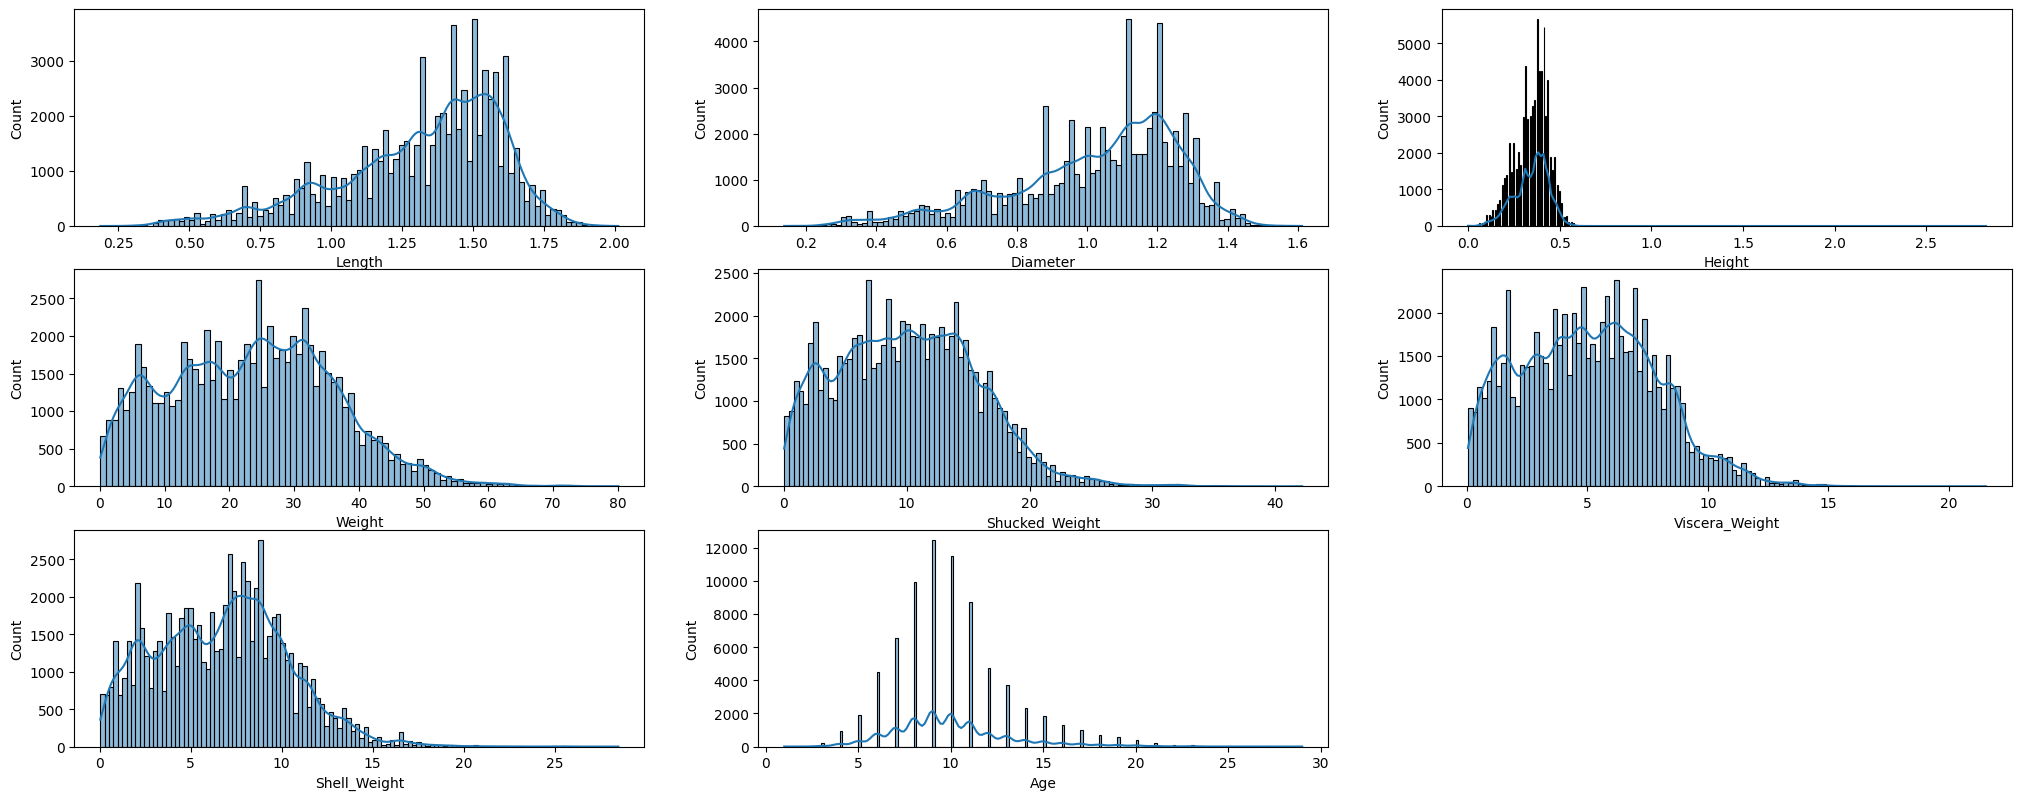

In [11]:
# Check distribution of features
num_data=train.select_dtypes(include='number')
plt.figure(figsize=(25,40), facecolor='white')
plotnumber =1
for col in num_data.columns:
      ax = plt.subplot(12,3,plotnumber)
      sns.histplot(x=train[col],kde=True,edgecolor='black',linewidth=0.8)
      plt.ticklabel_format(style='plain',axis='x')
      plt.xlabel(col)
      plotnumber+=1
plt.show()

In [12]:
# Check skew
train.skew(numeric_only=True)

Length           -0.844377
Diameter         -0.812866
Height            0.086578
Weight            0.231465
Shucked_Weight    0.349472
Viscera_Weight    0.286383
Shell_Weight      0.277459
Age               1.092919
dtype: float64

Length and Diameter and Age are morre skewwed compared to the rest. this will be handled later on.

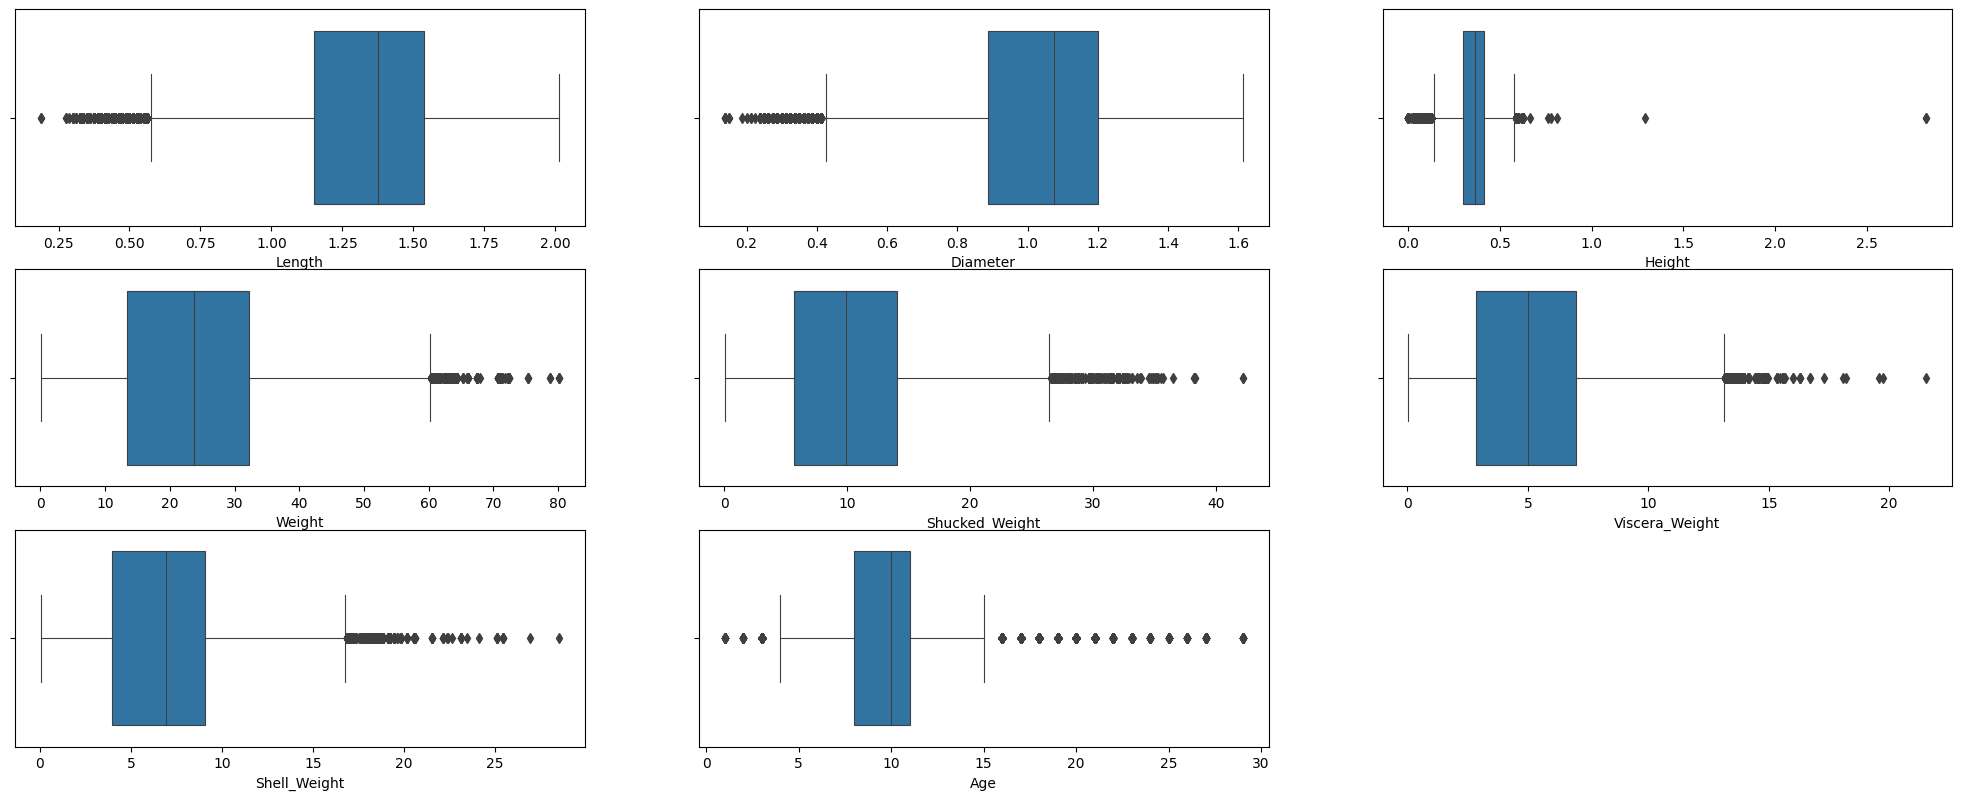

In [13]:
# Using boxplot to see proportion of outliers
plt.figure(figsize=(25,40), facecolor='white')
plotnumber =1
for col in num_data.columns:
      ax = plt.subplot(12,3,plotnumber)
      sns.boxplot(x=train[col],linewidth=0.8)
      plt.ticklabel_format(style='plain',axis='x')
      plt.xlabel(col)
      plotnumber+=1
plt.show()

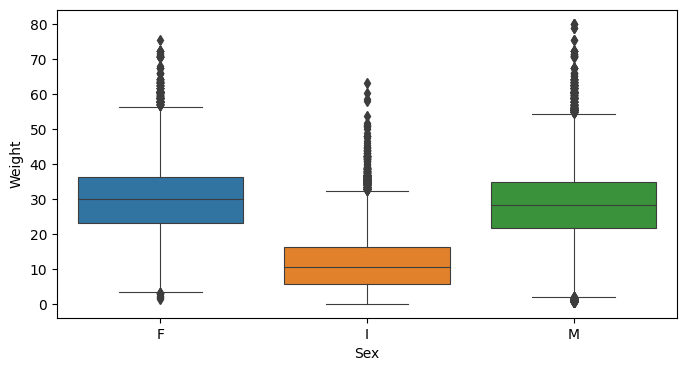

In [14]:
# Are male crabs heavier than female crabs
plt.figure(figsize=(8,4))
sns.boxplot(data=train,y='Weight',x='Sex',linewidth=0.8)
plt.show()

on average, female crabs are slightly higher weight

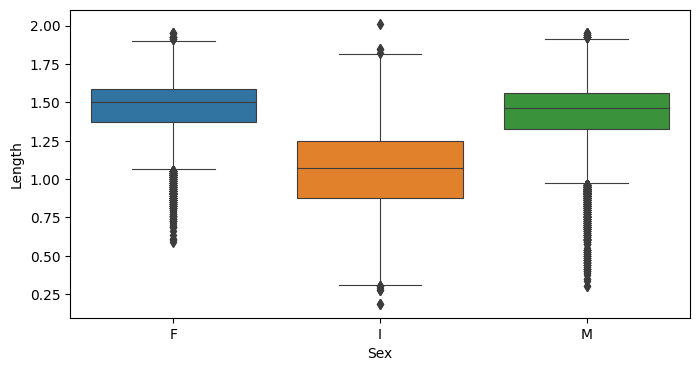

In [15]:
# Crab with more length
plt.figure(figsize=(8,4))
sns.boxplot(data=train,y='Length',x='Sex',linewidth=0.8)
plt.show()

female have slightly higher length than males, crabs with I -sex hae lower length on average

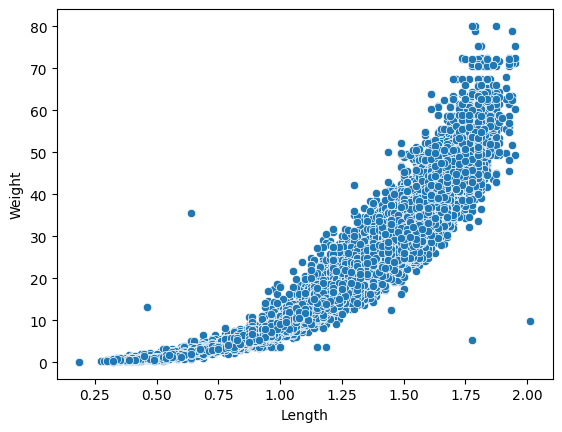

In [16]:
# Relationship between weight and height
sns.scatterplot(data=train,x='Length',y='Weight')
plt.show()

There is a strong relationship between weight and length, even though its not linear, its a strong positive relationship

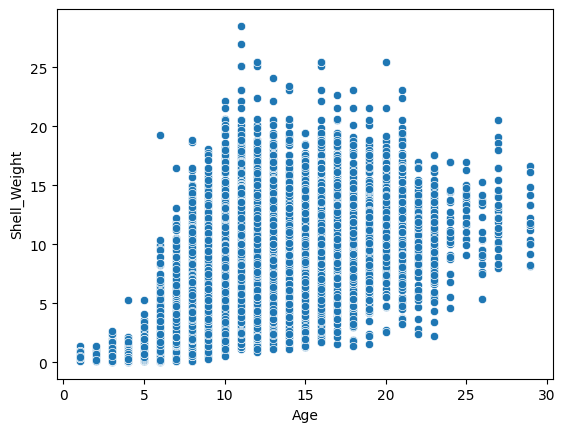

In [17]:
# Relationship between shell weight and age
sns.scatterplot(data=train,x='Age',y='Shell_Weight')
plt.show()

There is a strong correlation between shell weight and Age. As Age increases , shell weight increases.

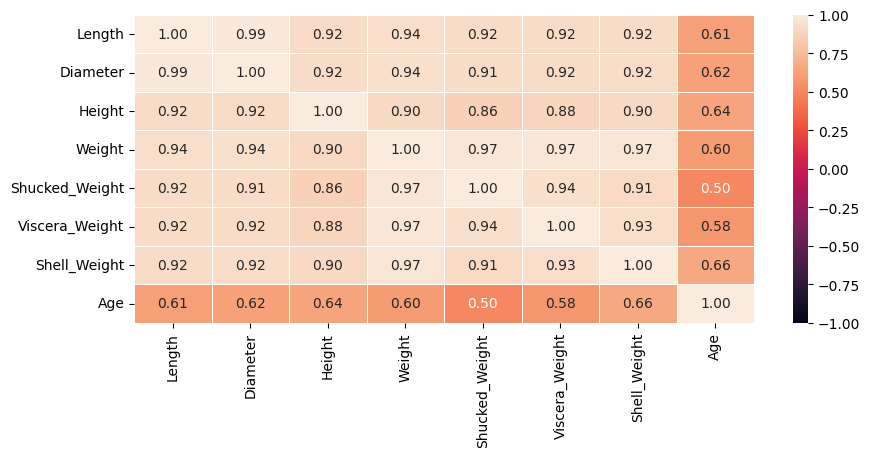

In [18]:
# Compute the correlation matrix
corr_matrix = num_data.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10,4))
sns.heatmap(corr_matrix, annot=True, vmin=-1, vmax=1,fmt='.2f',linewidth=0.7)
plt.show()

As expeted, all the variables are strongly correlated. since, we are concerned with prediction and not inference, multicolinearity is not much of an issue here.

In [19]:
# Separate features and target in train and test set
X_train=train.drop('Age',axis=1)
y_train=train['Age']

In [20]:
# Set callback for early stopping
callback=[lgb.early_stopping(5)]

# Transformer
power_transformer = PowerTransformer()

In [21]:
# Modelling
kf = KFold(n_splits=10, shuffle=True, random_state=12)
lgbm=lgb.LGBMRegressor(force_row_wise=True,n_estimators=125,importance_type="gain", random_state=12, n_jobs=-1)
model = TransformedTargetRegressor(regressor=lgbm, func=np.log,  inverse_func=np.exp)

# Get validation mae
valid_mae=[]
feature_importance = np.zeros(X_train.shape[1])

for train_idx, valid_idx in kf.split(X_train):
     X_train_fold, X_valid_fold = X_train.iloc[train_idx], X_train.iloc[valid_idx]
     y_train_fold, y_valid_fold = y_train.iloc[train_idx], y_train.iloc[valid_idx]
     model = model.fit(X_train_fold, y_train_fold, eval_set=(X_valid_fold, y_valid_fold),callbacks=callback,)
     y_pred=model.predict(X_valid_fold)
     mae=mean_absolute_error(y_valid_fold,y_pred)
     valid_mae.append(mae)
     # Accumulate feature importance
     feature_importance += model.regressor_.feature_importances_

print('-----------------------------------------------------')
print(f'\nMean validation MAE on 10 folds= {np.mean(valid_mae):.3f}')

[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 66645, number of used features: 8
[LightGBM] [Info] Start training from score 2.251031
Training until validation scores don't improve for 5 rounds
Did not meet early stopping. Best iteration is:
[125]	valid_0's l2: 68.5213
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 66646, number of used features: 8
[LightGBM] [Info] Start training from score 2.250183
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[78]	valid_0's l2: 69.1045
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the train set: 66646, number of used features: 8
[LightGBM] [Info] Start training from score 2.251039
Training until validation scores don't improve for 5 rounds
Early stopping, best iteration is:
[92]	valid_0's l2: 67.94
[LightGBM] [Info] Total Bins 1322
[LightGBM] [Info] Number of data points in the trai

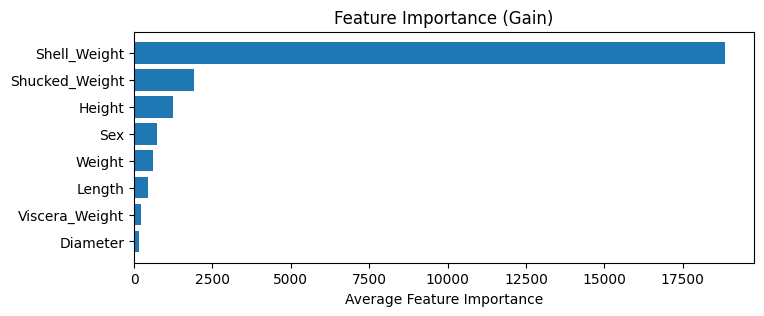

In [22]:
# Plot feature importance
avg_feature_importance = feature_importance / kf.get_n_splits()
feature_names = X_train.columns

# Create a dataframe for better visualization (optional)
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': avg_feature_importance})
importance_df = importance_df.sort_values(by='Importance', ascending=True)

# Plotting
plt.figure(figsize=(8, 3))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Average Feature Importance')
plt.title('Feature Importance (Gain)')
plt.show()

#### hyperparameter optimization

In [26]:
# Define objective
def objective(trial):
      params = {
        'boosting_type': trial.suggest_categorical("boosting_type", ["dart", "gbdt"]),
        'lambda_l1': trial.suggest_float('lambda_l1', 1e-8, 10.0, log=True),
        'lambda_l2': trial.suggest_float('lambda_l2', 1e-8, 10.0, log=True),
        'num_leaves': trial.suggest_int('num_leaves', 2, 256),
        'feature_fraction': trial.suggest_float('feature_fraction', 0.4, 1.0),
        'bagging_fraction': trial.suggest_float('bagging_fraction', 0.4, 1.0),
        'bagging_freq': trial.suggest_int('bagging_freq', 1, 7),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'learning_rate': trial.suggest_float("learning_rate", 0.0001, 0.5, log=True),
        'max_bin': trial.suggest_int("max_bin", 128, 512, 32),
        'n_estimators': trial.suggest_int("n_estimators", 40, 400, 20)}

      pruning_callback = optuna.integration.LightGBMPruningCallback(trial,'regression')

      model = lgb.LGBMRegressor(force_row_wise=True,**params,allbacks=[pruning_callback],verbose=-1)
      scores = -cross_val_score(model,X_train_fold, y_train_fold, scoring='neg_mean_absolute_error')
      return scores.mean()

In [ ]:
# Create study
sampler = optuna.samplers.TPESampler()
pruner = optuna.pruners.HyperbandPruner(min_resource=10, max_resource=400, reduction_factor=3)

study = optuna.create_study(direction='minimize', sampler=sampler, pruner=pruner)
study.optimize(objective, n_trials=100, gc_after_trial=True, n_jobs=-1)

[I 2023-11-24 18:46:59,854] A new study created in memory with name: no-name-301703da-df49-4ba9-938d-0dc96c82bffc
[I 2023-11-24 18:47:16,012] Trial 0 finished with value: 2.277805004464921 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 8.8021980957548, 'lambda_l2': 3.379709233411407e-05, 'num_leaves': 4, 'feature_fraction': 0.4819450978337308, 'bagging_fraction': 0.9166888022697812, 'bagging_freq': 3, 'min_child_samples': 81, 'learning_rate': 0.00026346862886141687, 'max_bin': 448, 'n_estimators': 180}. Best is trial 0 with value: 2.277805004464921.
[I 2023-11-24 18:47:51,627] Trial 1 finished with value: 3.1146914082636497 and parameters: {'boosting_type': 'gbdt', 'lambda_l1': 0.04420227255576294, 'lambda_l2': 1.1239484528304272e-07, 'num_leaves': 237, 'feature_fraction': 0.7247212527820865, 'bagging_fraction': 0.9734788546195496, 'bagging_freq': 6, 'min_child_samples': 15, 'learning_rate': 0.00018033098198188969, 'max_bin': 224, 'n_estimators': 200}. Best is trial 1 with valu